In [1]:
from neuprint import Client
from neuprint import NeuronCriteria as NC
from neuprint import fetch_neurons
from neuprint import fetch_adjacencies
from neuprint.utils import connection_table_to_matrix
import bokeh.palettes
from bokeh.plotting import figure, show, output_notebook
output_notebook()
import hvplot.pandas
import holoviews as hv
import numpy as np
import pandas as pd
import ants
import nibabel as nib
import os
import pickle
import scipy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import networkx as nx
from fa2 import ForceAtlas2
from nxviz import CircosPlot
import nxviz as nv
import tqdm
import time
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import bigbadbrain as bbb
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.colors as mcolors
import brainsss
import cv2

Loading BokehJS ...

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


# warp FDA PCA superclusters into luke

In [2]:
cluster_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221109_cluster_pca/"
file = os.path.join(cluster_dir, 'superclusters_more.npy')
superclusters = np.load(file)

In [3]:
superclusters.shape

(314, 146, 91, 499)

In [4]:
#with 249 there will be clusters 1-250 inclusive (len=250). cluster 140 is background
superclusters_250 = superclusters[:,:,:,249]
superclusters_250.shape

(314, 146, 91)

In [5]:
314/2

157.0

In [6]:
# right brain gets +250 to cluster ID so now 500 clusters
superclusters_250[157:,:,:] += 250

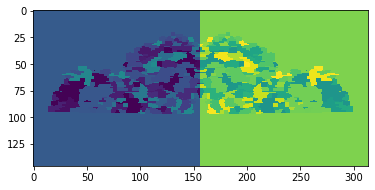

In [7]:
### CLUSTERS ARE SYMETRIC ACROSS MIDLINE SO NEED TO GIVE NEW IDs
plt.imshow(superclusters_250[:,:,30].T)

In [8]:
### Load Luke Mean ###
luke_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210310_luke_exp_thresh.nii"
res_luke_mean = (0.65,0.65,1)
luke_mean = np.asarray(nib.load(luke_path).get_data().squeeze(), dtype='float32')
luke_mean = luke_mean[:,:,::-1] #flipz
luke_mean = ants.from_numpy(luke_mean)
luke_mean.set_spacing(res_luke_mean)
luke_mean_lowres =  ants.resample_image(luke_mean,(256,128,49),use_voxels=True)

### Load JFRC2018 ###
fixed_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/JRC2018_FEMALE_38um_iso_16bit.nii"
res_JRC2018 = (0.38, 0.38, 0.38)
fixed = np.asarray(nib.load(fixed_path).get_data().squeeze(), dtype='float32')
fixed = ants.from_numpy(fixed)
fixed.set_spacing(res_JRC2018)
fixed_lowres = ants.resample_image(fixed,(2,2,2),use_voxels=False)

### Load Atlas ###
atlas_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/jfrc_2018_rois_improve_reorient_transformed.nii"
atlas = np.asarray(nib.load(atlas_path).get_data().squeeze(), dtype='float32')
atlas = ants.from_numpy(atlas)
atlas.set_spacing((.76,.76,.76))
atlas = ants.resample_image(atlas,(2,2,2),use_voxels=False)

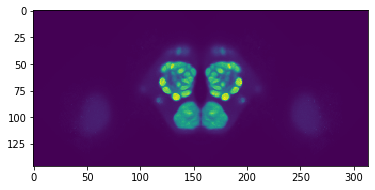

In [9]:
plt.imshow(fixed_lowres[:,:,20].T)

In [10]:
moving = ants.from_numpy(superclusters_250)
moving.set_spacing((2,2,2)) ### matching this to the slightly off luke mean
#moving.set_spacing((2.6076, 2.6154, 5.3125,1)) ### matching this to the slightly off luke mean

In [11]:
out = ants.registration(luke_mean_lowres, fixed_lowres, type_of_transform='Affine')

In [12]:
superclusters_250_in_luke = ants.apply_transforms(luke_mean_lowres,
                                       moving,
                                       out['fwdtransforms'][0],
                                       interpolator='nearestNeighbor')

In [13]:
superclusters_250_in_luke.shape

(256, 128, 49)

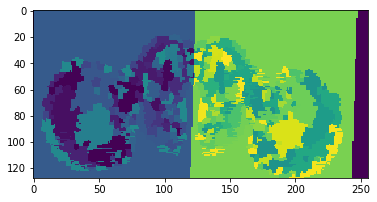

In [14]:
plt.imshow(superclusters_250_in_luke[:,:,10].T)

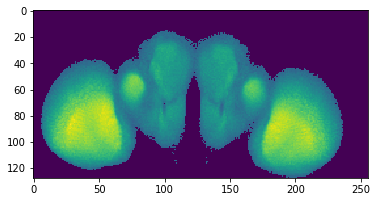

In [15]:
plt.imshow(luke_mean_lowres[:,:,10].T)

In [16]:
superclusters_250_in_luke_flat = np.reshape(superclusters_250_in_luke.numpy(),(256*128,49))
superclusters_250_in_luke_flat.shape

(32768, 49)

# get supercluster full signals

In [17]:
### Load Neural Data ###
all_neural = np.load('/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210514_for_aws/X_all_neural_z_vox_t_correct.npy')
all_neural.shape

(49, 2000, 30456)

In [18]:
### Load supervoxel labels ###
# I need the cluster_id for each supervoxel for neural analysis
# Issue: I think the PCs (on which I define clusters) did not use the 2000 supervoxels
n_clusters = 2000
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels.npy'
cluster_model_labels_2000 = np.load(labels_file)

In [19]:
cluster_model_labels_2000.shape

(49, 32768)

In [30]:
cluster = 17
z=22
cluster_indicies = np.where(superclusters_250_in_luke.numpy()[:,:,z]==cluster)
len(cluster_indicies[0])

104

In [31]:
colored_by_betas.shape

(256, 128, 30456)

In [33]:
colored_by_betas[cluster_indicies].shape

(104, 30456)

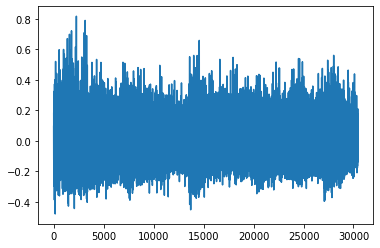

In [34]:
plt.plot(np.mean(colored_by_betas[cluster_indicies],axis=0))

In [ ]:
### THE PROBLEM WITH THIS STRATEGY IS LARGE SUPERCLUSTERS GET WAY BETTER SIGNAL BECAUSE MORE AVERAGES...

In [20]:
### I think I need neural data as (49,256,128,30456)
# and can only expand one slice at a time for memory

# initialize dictionaries
cluster_signal = {}
cluster_num_voxels = {}
for cluster in range(501):
    cluster_signal[cluster] = np.zeros((30456))
    cluster_num_voxels[cluster] = []

for z in range(9,49-10):
    print(z)
    colored_by_betas = np.zeros((256*128,30456))
    for cluster_num in range(len(np.unique(cluster_model_labels_2000[z]))):
        cluster_indicies = np.where(cluster_model_labels_2000[z]==cluster_num)[0]
        colored_by_betas[cluster_indicies,:] = all_neural[z,cluster_num,:]
    colored_by_betas = colored_by_betas.reshape(256,128,30456)

    # now loop over superclusters
    for cluster in range(501):
        cluster_indicies = np.where(superclusters_250_in_luke.numpy()[:,:,z]==cluster)
        cluster_num_voxels[cluster].append(len(cluster_indicies[0]))
        neural_signal = np.mean(colored_by_betas[cluster_indicies],axis=0)
        if np.sum(np.isnan(neural_signal)) > 0:
            continue
        cluster_signal[cluster] += neural_signal*len(cluster_indicies[0])

## normalize by number of voxels
for cluster in range(501):
    cluster_signal[cluster] /= np.sum(cluster_num_voxels[cluster])

9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


In [64]:
cluster_signal[100].shape

(30456,)

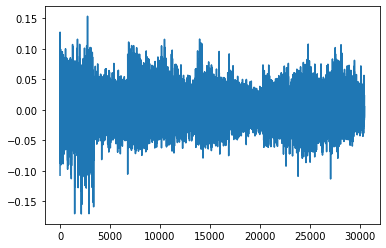

In [70]:
plt.plot(cluster_signal[1])

In [71]:
all_cluster_signals = np.zeros((501,30456))
for cluster in range(501):
    all_cluster_signals[cluster,:] = cluster_signal[cluster]

In [72]:
all_cluster_signals.shape

(501, 30456)

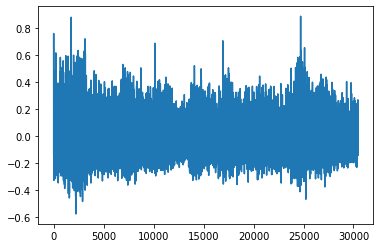

In [74]:
plt.plot(all_cluster_signals[250])

In [75]:
save_file = os.path.join(cluster_dir,"20221122_full_supercluster_recordings_250_hemi_doubled")
np.save(save_file,all_cluster_signals)

In [76]:
superclusters_250.shape

(314, 146, 91)